In [1]:
import sys
sys.path.append('/home/decker/lab433')

from synoptic import get_gfs1deg

from datetime import datetime, timedelta

import numpy as np
import xarray as xr
from metpy.units import units
from metpy.plots import ContourPlot, FilledContourPlot, BarbPlot, MapPanel, PanelContainer
import metpy.calc as mpcalc

In [2]:
init_time = datetime(2024, 9, 25, 6)
plot_time = init_time + timedelta(hours=30)
gfs = get_gfs1deg(init_time, plot_time)

In [3]:
ht300 = gfs['Geopotential_height_isobaric'].metpy.sel(vertical=300*units('hPa'))[:,10:81,180:310]
ht850 = gfs['Geopotential_height_isobaric'].metpy.sel(vertical=850*units('hPa'))[:,10:81,180:310]
u850 = gfs['u-component_of_wind_isobaric'].metpy.sel(vertical=850*units('hPa'))[:,10:81,180:310]
v850 = gfs['v-component_of_wind_isobaric'].metpy.sel(vertical=850*units('hPa'))[:,10:81,180:310]
u300 = gfs['u-component_of_wind_isobaric'].metpy.sel(vertical=300*units('hPa'))[:,10:81,180:310]
v300 = gfs['v-component_of_wind_isobaric'].metpy.sel(vertical=300*units('hPa'))[:,10:81,180:310]

### Panel 1

In [4]:
geoW850u, geoW850v = mpcalc.geostrophic_wind(ht850)
geoW300u, geoW300v = mpcalc.geostrophic_wind(ht300)

u = geoW850u.rename('u')
v = geoW850v.rename('v')
geoW850 = xr.merge([u, v])

u = geoW300u.rename('u')
v = geoW300v.rename('v')
geoW300 = xr.merge([u, v])

tWind = geoW300 - geoW850

In [5]:
thermWind = BarbPlot()
thermWind.data = tWind
thermWind.time = plot_time
thermWind.color = 'maroon'
thermWind.field = ['u', 'v']
thermWind.skip = (4, 3)
thermWind.plot_units = 'knot'

g300 = BarbPlot()
g300.data = geoW300
g300.time = plot_time
g300.color = 'magenta'
g300.field = ['u', 'v']
g300.skip = (6, 3)
g300.plot_units = 'knot'

panel1 = MapPanel()
panel1.layout = (2, 2, 1)
panel1.area = [-160, -100, 35, 65]
panel1.projection = 'mer'
panel1.layers = ['states', 'coastline', 'borders']
panel1.title = f'Sea-Level Pressure and 1000-500 mb Thickness at {plot_time}'
panel1.plots = [thermWind, g300]

### Panel 2

In [6]:
t = init_time + timedelta(hours=36)
t2 = init_time + timedelta(hours=24)

slp1 = get_gfs1deg(init_time, t)
slp2 = get_gfs1deg(init_time, t2)
mslp1 = slp1['MSLP_Eta_model_reduction_msl']
mslp2 = slp2['MSLP_Eta_model_reduction_msl']

iD = mpcalc.first_derivative(geoW850u, axis = 'x')
iD2 = mpcalc.first_derivative(geoW850u, axis = 'y')
iU = iD * tWind['u']
iV = iD2 * tWind['v']

jD = mpcalc.first_derivative(geoW850v, axis = 'x')
jD2 = mpcalc.first_derivative(geoW850v, axis = 'y')
jU = jD * tWind['u']
jV = jD2 * tWind['v']

i = (iU + iV).rename('horizontal')
j = (jU + jV).rename('vertical')
Wshear = xr.merge([j, i])

In [7]:
shear = BarbPlot()
shear.data = Wshear
shear.time = plot_time
shear.color = 'black'
shear.field = ['horizontal', 'vertical']
shear.scale = 3e4
shear.skip = (4,3)

panel2 = panel1.copy()
panel2.layout = (2, 2, 2)
panel2.title = f'Surface Wind Shear (kt) at {plot_time}'
panel2.plots = [shear]

### Panel 3

In [8]:
coriolis = mpcalc.coriolis_parameter(Wshear['latitude'])
wC = Wshear/(coriolis)
diverge = mpcalc.divergence(wC['horizontal'], wC['vertical'])
gauss = mpcalc.smooth_gaussian(diverge, 8)

In [9]:
div = ContourPlot()
div.data = gauss
div.time = plot_time
div.contours = range(1,35,2)
div.scale = 1e5
div.linecolor = 'cyan'
div.linestyle = 'solid'
div.clabels = True
div.plot_units = '1/s'

div2 = ContourPlot()
div2.data = gauss
div2.time = plot_time
div2.contours = range(-35,-1,2)
div2.scale = 1e5
div2.linecolor = 'navy'
div2.linestyle = 'dashed'
div2.clabels = True
div2.plot_units = '1/s'

panel3 = panel1.copy()
panel3.layout = (2, 2, 3)
panel3.title = f'Change in Divergence w Height According to Shearing over Surface Wind Term at {plot_time}'
panel3.plots = [div, div2]

### Panel 4

In [10]:
isallo = mslp1.squeeze('time1') - mslp2.squeeze('time1')

In [11]:
isallobars = ContourPlot()
isallobars.data = isallo
isallobars.contours = range(0, 1000, 3)
isallobars.linecolor = 'firebrick'
isallobars.linestyle = 'solid'
isallobars.clabels = True
isallobars.plot_units = 'hPa'

isallobars2 = ContourPlot()
isallobars2.data = isallo
isallobars2.contours = range(-1000, 0, 3)
isallobars2.linecolor = 'gold'
isallobars2.linestyle = 'dashed'
isallobars2.clabels = True
isallobars2.plot_units = 'hPa'

panel4 = panel1.copy()
panel4.layout = (2, 2, 4)
panel4.title = f'Isallobars at {plot_time}'
panel4.plots = [isallobars, isallobars2]

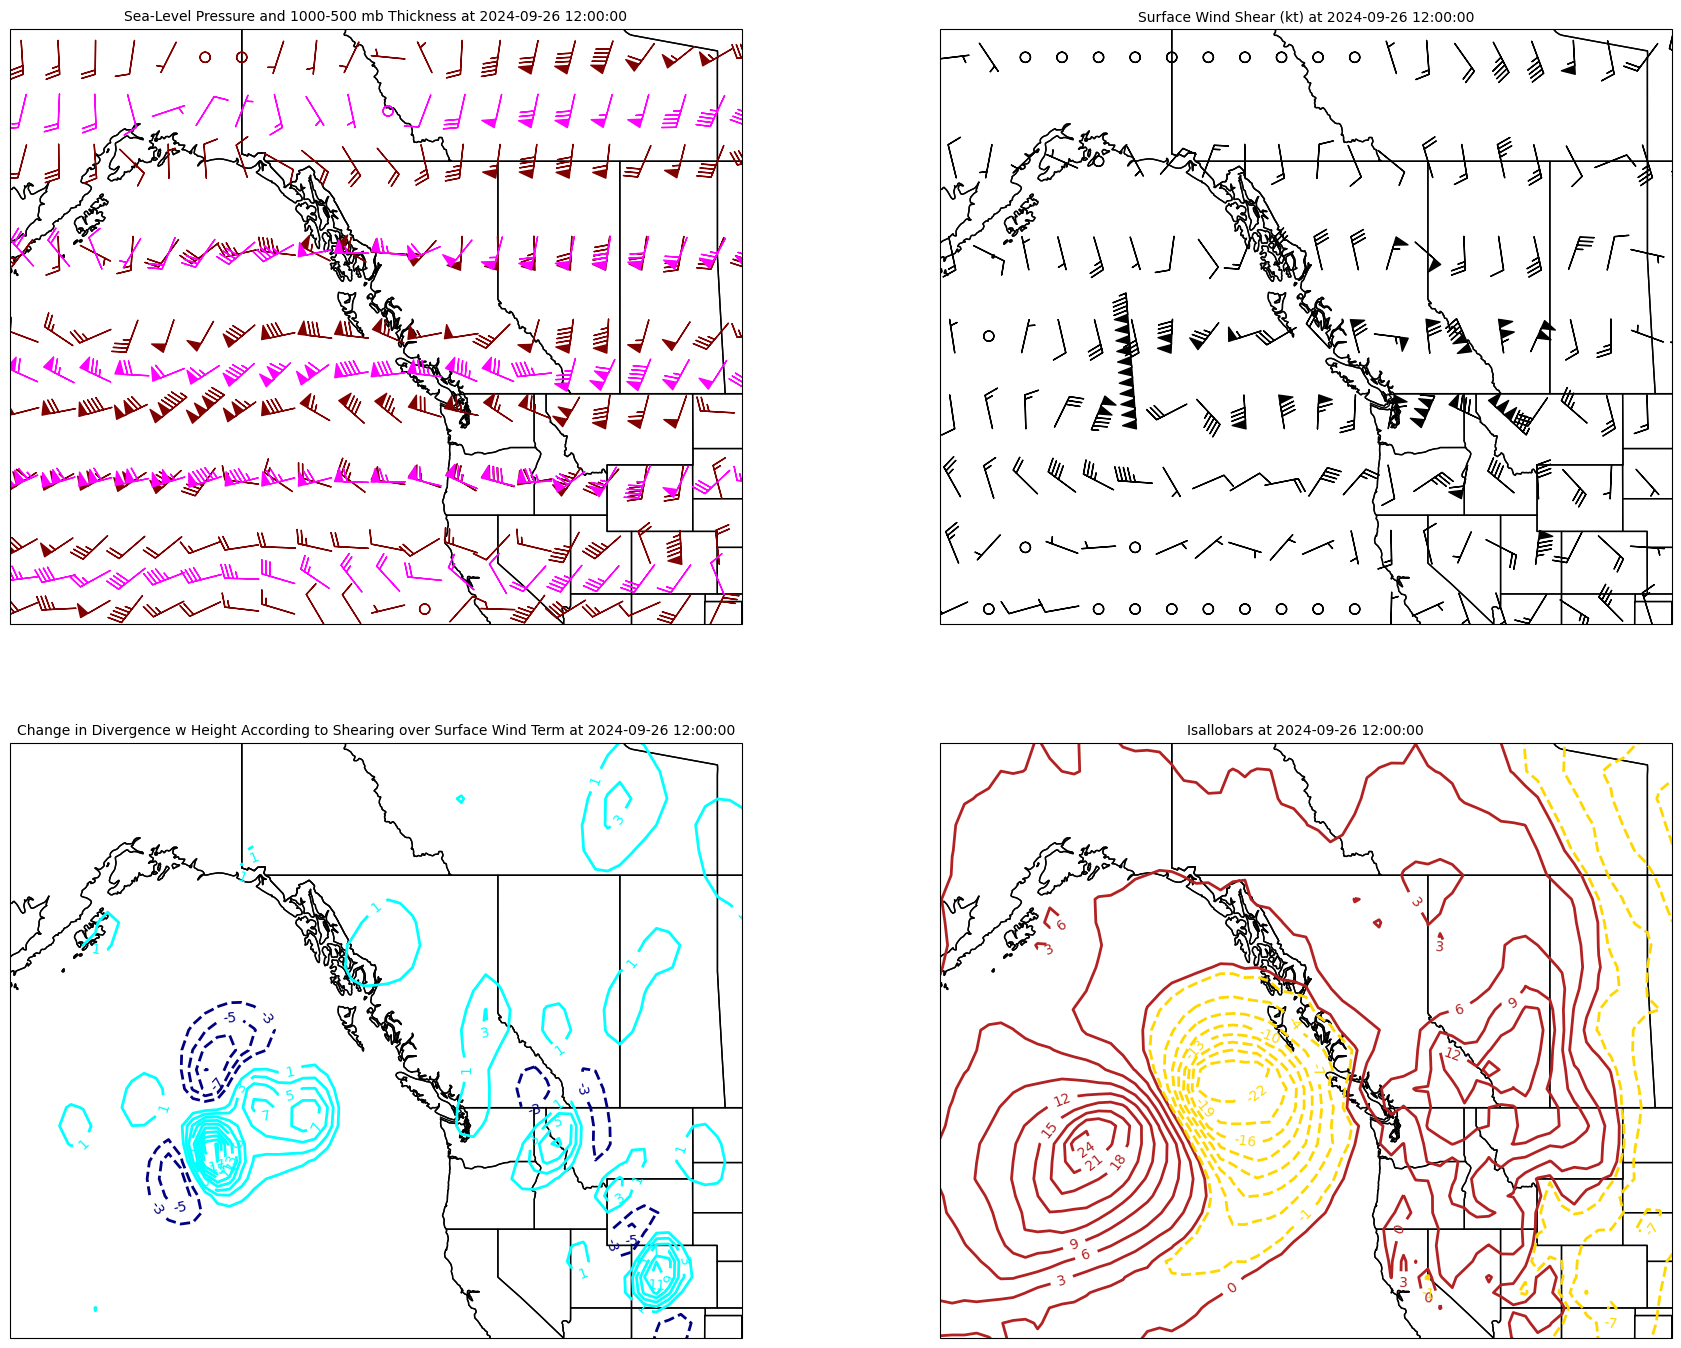

In [12]:
pc = PanelContainer()
pc.size = (22,17)
pc.panels = [panel1, panel2, panel3, panel4]
pc.show()